Source: https://github.com/moassem89/Neural-Networks-for-Differential-Equations

In [1]:
#import autograd.numpy as np 
#from autograd import grad, jacobian
#import autograd.numpy.random as npr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot, cm
from mpl_toolkits.mplot3d import Axes3D 
%matplotlib inline
import itertools

In [2]:
def f(number): #the right-hand-side of Laplace. Here we consider the simple case f is the zero function. You my use another f 
    return 0.

def sigmoid(number):
    return 1. / (1. + np.exp(-number))


def diff_sigmoid(number):
    return sigmoid(number) * (1 - sigmoid(number))


def diff2_sigmoid(number):
    s = sigmoid(number)
    return s * (1 - s) * (1 - 2 * s)

def diff3_sigmoid(number):
    s = sigmoid(number)
    return 1 - 6* s+ 2* s**3


In [3]:
#The Neural Network: Input layer of 2 neurons (one for each input x,y) | One hidden layer of 20 neurons| Output 1 value 

#Recall: [...] is a column with shape (len,). It is often needed to reshape it as (len,1), i.e., [[],...,[]]
#[[....]] is a single row (1,len), [[...],[...],[...]] matrix of three rows



def N(W0,W1, grid):  #W0 going to be 2x20, W1 20x1, grid 10000x2 (Ten thousand inputs each is an ordered pair x,y) 
                     #W0 = [a,b], a=[[a1, ..., a20]], b=[[b1,...,b20]] 
                     #W1 = [r1,...,r20]
    v = sigmoid(np.matmul(grid, W0)) #10000x20:
                                     #v=[[s(a1x0+b1y0),..,s(a20x0+b20y0)],...,[s(a1x99+b1y99),..,s(a20x99+b20y99)]]
        
    return np.matmul(v, W1)      #10000x1 (output for each point on the grid)
                                 #[Sum{ri s(aix0+biy0)}, ..., Sum{ri s(aix99+biy99)}]

#Returns [N(x0,y0), ...., N(x99,y99)]


##################

def first_order_partials_N(W0, W1, grid):  #W0 going to be 2x20, W1 20x1, grid 10000x2 -- 
                                           #W0 = [a,b], a=[[a1, ..., a20]], b=[[b1,...,b20]] 
                                           #W1 = [[r1],...,[r20]]
                                           #grid = [[x0,y0],..,[x0,y99],[x1,y0],..,[x1,y99],...,[x99,y0],..[x99,y99]]
    a = W0[0,:].reshape(1,len(W0[0,:]))      #1x20 (First row in W0). Before reshaping it is (len,)
    b = W0[1,:].reshape(1,len(W0[0,:]))      #1x20 (Second row in W0)
    
  # W0 = [a,b] = [[a1, ..., a20],...,[b1, ..., b20]]

    ds_dx = diff_sigmoid (np.matmul(grid, W0))      #10000x20 matrix multiplication
                                      #np.matmul(grid, W0)=[[a1x0+b1y0,..,a20x0+b20y0],...,[a1x99+b1y99,..,a20x99+b20y99]]
        
    W1a = np.multiply(W1.T,a)     #1x20: component-wise multiplication(Hadamard) [[r1a1,...,r20a20]]
    W1b = np.multiply(W1.T,b)     #[[r1b1,...,r20b20]]
    Nx = np.matmul(W1a, ds_dx.T)      #1x10000: [[Sum{riai s'(aix0+biy0)}, ..., Sum{riai s'(aix99+biy99)}]]
    Ny = np.matmul(W1b, ds_dx.T)      #1x10000: [[Sum{riai s'(aix0+biy0)}, ..., Sum{riai s'(aix99+biy99)}]]
    
    return np.vstack((Nx, Ny))  #This function returns a 2x10000 vector (the numerical value of partial derivs at each tuple)

#In other words, returns [[Nx(x0,y0), ..., Nx(x99,y99)],[Ny(x0,y0), ..., Ny(x99,y99)]]

###############

def second_order_partials_N(W0, W1, grid):  #W0 going to be 2x20, W1 20x1, grid 10000x1 -- 
                                            #W0 = [a,b], a=[[a1, ..., a20]], b=[[b1,...,b20]] 
                                            #W1 = [r1,...,r20]
                                            #grid = [[x0,y0],..,[x0,y99],[x1,y0],..,[x1,y99],...,[x99,y0],..[x99,y99]]
    a_s = W0[0,:] ** 2 #compnent-wise squaring
    b_s = W0[1,:] ** 2
    
    #W0**2 = [a_s, b_s]
    
    ds_dx_2 = diff2_sigmoid(np.matmul(grid, W0))  #10000x20
    W1a_s = np.multiply(W1.T,a_s.reshape(1,len(W0[0,:])))   #1x20 
    W1b_s = np.multiply(W1.T,b_s.reshape(1,len(W0[0,:])))
    Nxx = np.matmul(W1a_s,ds_dx_2.T)    #1x10000: [[Sum{riai^2 s''(aix0+biy0)}, ..., Sum{riai^2 s''(aix99+biy99)}]]
    Nyy = np.matmul(W1b_s,ds_dx_2.T)
    return np.vstack((Nxx, Nyy))

#Returns [[Nxx(x0,y0), ..., Nxx(x99,y99)],[Nyy(x0,y0), ..., Nyy(x99,y99)]]



In [4]:
#A(x,y) = y sin(Pi * x)

def Axx(grid):  # grid is going to be 10000 x 2 (i.e. 10000 ordered pairs) 
    
    x =  grid[:,0].reshape(len(grid),1)
    y =  grid[:,1].reshape(len(grid),1)
    A = np.multiply(y, np.sin(np.pi * x))#10000x1: 
                                                     # [y0sin(Pix0),..,y99sin(Pix0),..,y0sin(Pix99),..,y99sin(Pix99)]
    return - np.pi ** 2 * A   #10000x1


def second_order_partials_A(grid):
    A_xx = Axx(grid)   #10000x1
    A_yy = np.zeros_like(A_xx)  #same shape as Axx but all zeros
    return np.vstack((A_xx.T, A_yy.T)) #2x10000: glued them as rows

In [5]:
#Now we can define the second order partial derivatives of Psi

def second_order_partials_Psi(W0, W1, grid):
    
    Ahess = second_order_partials_A(grid)
    
    J = first_order_partials_N(W0, W1, grid) #Jacobian (just reminder)
    H = second_order_partials_N(W0, W1, grid) #Hessian
    
    ####
    
    x = grid[:,0].reshape(len(grid),1)  #x = [[x0], ..., [x0], [x1], ..., [x1], ..., [x99], ..., [x99]] which is 10000x1
    y = grid[:,1].reshape(len(grid),1) #y = [[y0], ..., [y99], [y0], ..., [y99], ..., [y0], ..., [y99] which is 10000x1
    y_one_minus_y = np.multiply(y, (1 - y)) #[[y0(1-y0)],..,[y99(1-y99)], ..., [y0(1-y0)],..,[y99(1-y99)]]
    x_one_minus_x = np.multiply(x, (1 - x)) #[[x0(1-x0)],..,[x0(1-x0)],[x1(1-x1)], ..,[x1(1-x1)],...,[x99(1-x99)],..,[x99(1-x99)]]
    
    one_minus = np.vstack((y_one_minus_y.T, x_one_minus_x.T))
    
    ####
    minus_2x =  2 * (1 - 2 * x)     #[[2(1-2x0)],..,[2(1-2x0)],[2(1-2x1)], ..,[2(1-2x1)],...,[2(1-2x99)],..,[2(1-2x99)]]
    minus_2y = 2 * (1 - 2 * y)  
    
    minus_2 = np.vstack((minus_2x.T, minus_2y.T))   #2x10000
    ####
    
    two_N = np.vstack((N(W0,W1,grid).T,N(W0,W1,grid).T))  #2x10000
    ####
    
    one_minus_flip = np.vstack((x_one_minus_x.T, y_one_minus_y.T)) #one_minus after swapping the two rows 
    ####
    
    #Now we can put all component-wise
    Psihess = Ahess + np.multiply(one_minus, -2 * two_N + np.multiply(minus_2, J) + np.multiply(one_minus_flip, H))
    
    ####
    return Psihess  #2x10000

In [6]:
#Let's plot the analytic solution and the neural solution to get an idea. Keep in mind we haven't trained the nn yet.

def analytic_solution(point):  #at a single point 2x1
    return (1 / (np.exp(np.pi) - np.exp(-np.pi))) * \
            np.sin(np.pi * point[0]) * (np.exp(np.pi * point[1]) - np.exp(-np.pi * point[1]))

def A(point):
    return point[1] * np.sin(np.pi * point[0])

def neural_solution(W0,W1,point): #which is Psi_trial
    return A(point) + point[0] * (1 - point[0]) * point[1] * (1 - point[1]) * (N(W0,W1,point)[0])

In [7]:
#pick weights randomly 

W0 = np.random.randn(2, 20)
W1 = np.random.randn(20, 1)


#Define the grid

x_space = np.linspace(0, 1, 100)
y_space = np.linspace(0, 1, 100)

grid = np.array(list(itertools.product(x_space,y_space))) ## cross-product

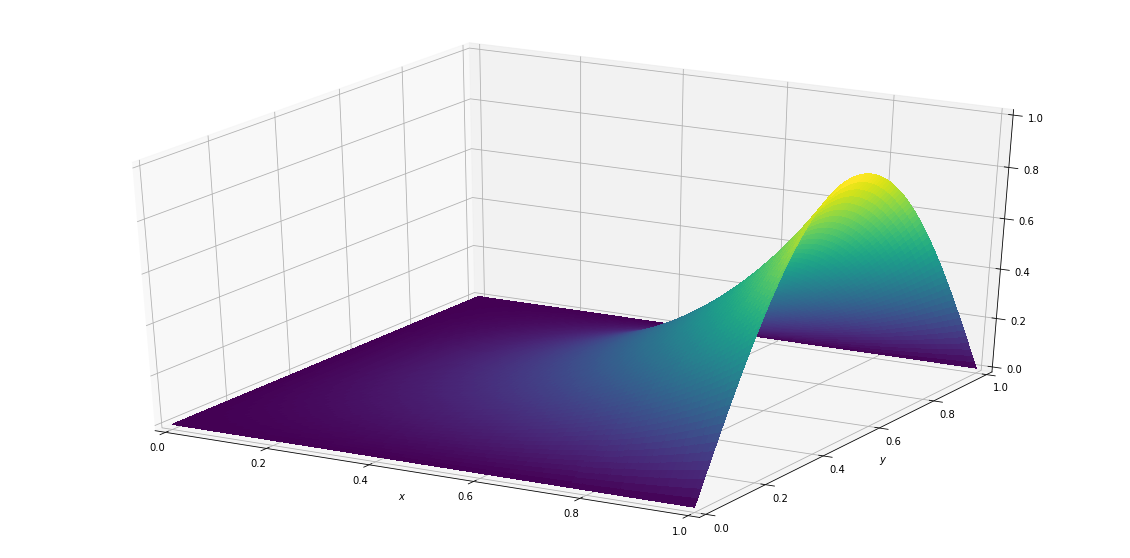

In [8]:
#Plot the analytic solution

analytic_surface = np.zeros((100, 100)) 
for i,x in enumerate(x_space):
    for j,y in enumerate(y_space):
        analytic_surface[i][j] = analytic_solution([x, y])

        

fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, analytic_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

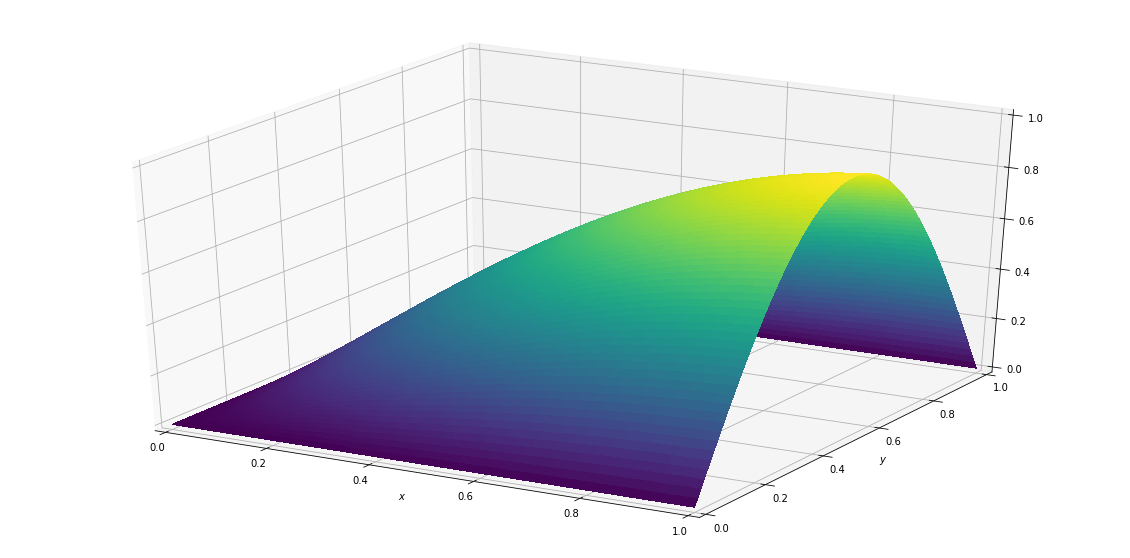

In [9]:
#Plot the neural solution before training 

neural_surface = np.zeros((100, 100))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):  
        neural_surface[i][j] = neural_solution(W0,W1,[x, y])


fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, neural_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [10]:
#Result looking very bad, wait until we train our network, it will be even better


#First, define our loss function

def loss_function(W0, W1, grid):
    #func = f(grid) # right hand side #  we will solve for   func = 0 but keeping our code generalizable
    
    Psixx_plus_Psiyy = np.sum(second_order_partials_Psi(W0, W1, grid), axis = 0) #left hand side #We sum the two rows of Psihess
    
    err_sqr = Psixx_plus_Psiyy **2
    #err_sqr = (dxx_plus_dyy - func)**2
    loss_sum = np.mean(err_sqr) #note that this approximates the L2 distance (integral)
        
    return loss_sum * 10e-6 #dividing by a million for numerical stability



#Define the gradient -- partial derivs w.r.t. W0,W1 -- of the loss function
#We need to find the gradients of N,Nx,Ny,Nxx,Nyy
#Note that partial derivs w.r.t. W0,W1 mean w.r.t. a1,..,a20,b1,..,b20,r1,..,r20
#More clearly, NW0 = [[Na1, ..,Na20],[Nb1,..,Nb20]] which is 2x20 like W0. Similarly, NW1
#With 10000 points, we put all the NW0(x,y) together in a 10000x2x20 tensor
#NW1 does not need a third dimension as NW1(x,y) is only one dimensional: 20x1. NW1 is 10000x20


#Recall, N = Sum ri s(aix+biy). So we have Naj = rj x s'(ajx+bjy),Nbj = rj y s'(ajx+bjy), Nrj = s(ajx+bjy). Hence,


def N_W0(W0,W1, grid): #point will be on the form [[x,y]] which is 1x2. We do this so N_W0 can extend automatically to grid
    
    ds_dx = diff_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    

    Na = np.multiply(W1.T, np.multiply(X,ds_dx)) #tensx20
    Nb = np.multiply(W1.T, np.multiply(Y,ds_dx))
  
    return   np.column_stack((Na,Nb)).reshape(len(grid),2,len(W1)) #np.array([np.vstack((Na,Nb))]) #40xtens.
#We took column_stack to make the value at every point in a separate column. 
#Otherwise, we get all the Na separate from the Nb #2x20 same size as W0 

#Just make sure after you apply N_W0 to grid, reshape to (10000,2,20) as before reshaping it comes as (1,20000,20)

def N_W1(W0,W1, grid):
    return sigmoid(np.matmul(grid, W0)) #tensx20

##############

#Now, Nx = Sum riai s'(aix+biy)
#So we have Nxaj = rj s'(ajx+bjy) + rjajx s''(ajx+bjy), Nxbj = rjaj y s''(ajx+bjy), Nxrj = aj s'(ajx+bjy). Hence,

def Nx_W0(W0,W1,grid):
    
    ds_dx = diff_sigmoid (np.matmul(grid, W0))  #10000x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:].reshape(1,len(W0[0,:]))
    b = W0[1,:].reshape(1,len(W0[0,:]))

    Nxa = np.multiply(W1.T, ds_dx) + np.multiply(W1.T, np.multiply(X,np.multiply(a, ds_dx_2))) #10000x20
    Nxb = np.multiply(W1.T, np.multiply(a,np.multiply(Y, ds_dx_2)))
  
    return np.column_stack((Nxa,Nxb)).reshape(len(grid),2,20) #np.array([np.vstack((Nxa,Nxb))]) #40xtens.
#We took column_stack to make the value at every point in a separate column. 
#Otherwise, we get all the Nxa separate from the Nxb #2x20 same size as W0 


def Nx_W1(W0,W1,point):
    ds_dx = diff_sigmoid (np.matmul(grid, W0))
    a = W0[0,:].reshape(1,len(W0[0,:]))
    return np.multiply(a, ds_dx) #tensx20
    

######################### Symmetry, let's do Ny
#Now, Ny = Sum ribi s'(aix+biy)
#So we have Nybj = rj s'(ajx+bjy) + rjbjy s''(ajx+bjy), Nyaj = rjbj x s''(ajx+bjy), Nyrj = bj s'(ajx+bjy)
#Remember:  Nxaj = rj s'(ajx+bjy) + rjajx s''(ajx+bjy), Nxbj = rjaj y s''(ajx+bjy), Nxrj = aj s'(ajx+bjy). Hence,

def Ny_W0(W0,W1,grid):
    
    ds_dx = diff_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0)) #10000x20
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:].reshape(1,len(W0[0,:]))
    b = W0[1,:].reshape(1,len(W0[0,:]))

    Nyb = np.multiply(W1.T, ds_dx) + np.multiply(W1.T, np.multiply(Y,np.multiply(b, ds_dx_2))) #1x20
    Nya = np.multiply(W1.T, np.multiply(b,np.multiply(X, ds_dx_2)))
  
    return np.column_stack((Nya,Nyb)).reshape(len(grid),2,len(W1)) #np.array([np.vstack((Nya,Nyb))]) #40xtens.
#We took column_stack to make the value at every point in a separate column. 
#Otherwise, we get all the Nya separate from the Nyb 


def Ny_W1(W0,W1,grid):
    ds_dx = diff_sigmoid (np.matmul(grid, W0))
    b = W0[0,:].reshape(1,len(W0[0,:]))
    return np.multiply(b, ds_dx) #tensx20
    
    


In [11]:
#Now, Nxx = Sum ri ai^2 s''(aix+biy)
#So we have Nxxaj = 2rjaj s''(ajx+bjy) + rjaj^2x s'''(ajx+bjy), Nxxbj = rjaj^2y s'''(ajx+bjy), Nxxrj = aj^2 s''(ajx+bjy)

def Nxx_W0(W0,W1,grid):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:].reshape(1,len(W0[0,:]))
    b = W0[1,:].reshape(1,len(W0[0,:]))

    Nxxa = np.multiply(2*W1.T, np.multiply(a,ds_dx_2)) + np.multiply(W1.T, np.multiply(X,np.multiply(a**2, ds_dx_3)))#tensx20
    Nxxb = np.multiply(W1.T, np.multiply(a**2,np.multiply(Y, ds_dx_3)))
  
    return np.column_stack((Nxxa,Nxxb)).reshape(len(grid),2,len(W1)) #np.array([np.vstack((Nxxa,Nxxb))]) #40xtens.
#We took column_stack to make the value at every point in a separate column. 
#Otherwise, we get all the Nxxa separate from the Nxxb


def Nxx_W1(W0,W1,grid):
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    a = W0[0,:].reshape(1,len(W0[0,:]))
    return np.multiply(a**2, ds_dx_2)

###################

#Silimarly, Nyy

#Now, Nyy = Sum ri bi^2 s''(aix+biy)
#So we have Nyybj = 2rjbj s''(ajx+bjy) + rjbj^2y s'''(ajx+bjy), Nyyaj = rjbj^2x s'''(ajx+bjy), Nyyrj = bj^2 s''(ajx+bjy)

def Nyy_W0(W0,W1,grid):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)] : x,y in grid]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:].reshape(1,len(W0[0,:]))
    b = W0[1,:].reshape(1,len(W0[0,:]))

    Nyyb = np.multiply(2*W1.T, np.multiply(b,ds_dx_2)) + np.multiply(W1.T, np.multiply(Y,np.multiply(b**2, ds_dx_3))) 
    Nyya = np.multiply(W1.T, np.multiply(b**2,np.multiply(X, ds_dx_3)))   #tensx20
  
    return np.column_stack((Nyya,Nyyb)).reshape(len(grid),2,len(W1)) #np.array([np.vstack((Nyya,Nyyb))]) #40xtens: We took column_stack to make \n
#the value at every point in a separate column. Otherwise, we get all the Nyya separate from the Nyyb



def Nyy_W1(W0,W1,grid):
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0)) #tensx20
    b = W0[1,:].reshape(1,len(W0[0,:]))
    return np.multiply(b**2, ds_dx_2) #tensx20

In [12]:
#Here is what we did above but for a single point. 
#This was an earlier way but we chose not to delete it as it might be a useful code
#Define the gradient -- partial derivs w.r.t. W0,W1 -- of the loss function
#We need to find the gradients of N,Nx,Ny,Nxx,Nyy
#Note that partial derivs w.r.t. W0,W1 mean w.r.t. a1,..,a20,b1,..,b20,r1,..,r20
#More clearly, NW0 = [[Na1, ..,Na20],[Nb1,..,Nb20]] which is 2x20 like W0. Similarly, NW1


#Recall, N = Sum ri s(aix+biy). So we have Naj = rj x s'(ajx+bjy),Nbj = rj y s'(ajx+bjy), Nrj = s(ajx+bjy). Hence,


def NN_W0(W0,W1, point): #point will be on the form [[x,y]] which is 1x2. We do this so N_W0 can extend automatically to grid
    
    ds_dx = diff_sigmoid (np.matmul(point, W0))  #1x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    
    X = np.array([point[0][0]])
    Y = np.array([point[0][1]])

    Na = np.multiply(W1.T, np.multiply(X,ds_dx)) #1x20
    Nb = np.multiply(W1.T, np.multiply(Y,ds_dx))
  
    return  np.array([np.vstack((Na,Nb))]) #2x20 same size as W0 which is expected

#Just make sure after you apply N_W0 to grid, reshape to (10000,2,20) as before reshaping it comes as (1,20000,20)

def NN_W1(W0,W1, point):
    return sigmoid(np.matmul(point, W0).T) #20x1 and extend naturally to grid to give 20x10000

##############

#Now, Nx = Sum riai s'(aix+biy)
#So we have Nxaj = rj s'(ajx+bjy) + rjajx s''(ajx+bjy), Nxbj = rjaj y s''(ajx+bjy), Nxrj = aj s'(ajx+bjy). Hence,

def NNx_W0(W0,W1,point):
    
    ds_dx = diff_sigmoid (np.matmul(point, W0))  #1x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(point, W0))
    
    X = np.array([point[0][0]])
    Y = np.array([point[0][1]])
    
    a = W0[0,:]
    b = W0[1,:]

    Nxa = np.multiply(W1.T, ds_dx) + np.multiply(W1.T, np.multiply(X,np.multiply(a, ds_dx_2))) #1x20
    Nxb = np.multiply(W1.T, np.multiply(a,np.multiply(Y, ds_dx_2)))
  
    return np.array([np.vstack((Nxa,Nxb))]) #2x20 same size as W0 


def Nx_W1(W0,W1,point):
    ds_dx = diff_sigmoid (np.matmul(point, W0))
    a = W0[0,:]
    return np.multiply(a, ds_dx)
    

######################### Symmetry, let's do Ny
#Now, Ny = Sum ribi s'(aix+biy)
#So we have Nybj = rj s'(ajx+bjy) + rjbjy s''(ajx+bjy), Nyaj = rjbj x s''(ajx+bjy), Nyrj = bj s'(ajx+bjy)
#Remember:  Nxaj = rj s'(ajx+bjy) + rjajx s''(ajx+bjy), Nxbj = rjaj y s''(ajx+bjy), Nxrj = aj s'(ajx+bjy). Hence,

def NNy_W0(W0,W1,point):
    
    ds_dx = diff_sigmoid (np.matmul(point, W0))  #1x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(point, W0))
    
    X = np.array([point[0][0]])
    Y = np.array([point[0][1]])
    
    a = W0[0,:]
    b = W0[1,:]

    Nyb = np.multiply(W1.T, ds_dx) + np.multiply(W1.T, np.multiply(Y,np.multiply(b, ds_dx_2))) #1x20
    Nya = np.multiply(W1.T, np.multiply(b,np.multiply(X, ds_dx_2)))
  
    return np.vstack((Nya,Nyb)) #np.array([np.vstack((Nya,Nyb))]) #2x20 same size as W0 


def NNy_W1(W0,W1,point):
    ds_dx = diff_sigmoid (np.matmul(point, W0))
    b = W0[0,:]
    return np.multiply(b, ds_dx)
    

In [13]:
#Now, Nxx = Sum ri ai^2 s''(aix+biy)
#So we have Nxxaj = 2rjaj s''(ajx+bjy) + rjaj^2x s'''(ajx+bjy), Nxxbj = rjaj^2y s'''(ajx+bjy), Nxxrj = aj^2 s''(ajx+bjy)

def NNxx_W0(W0,W1,point):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(point, W0))  #1x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(point, W0))
    
    X = np.array([point[0][0]])
    Y = np.array([point[0][1]])
    
    a = W0[0,:]
    b = W0[1,:]

    Nxxa = np.multiply(2*W1.T, np.multiply(a,ds_dx_2)) + np.multiply(W1.T, np.multiply(X,np.multiply(a**2, ds_dx_3))) #1x20
    Nxxb = np.multiply(W1.T, np.multiply(a**2,np.multiply(Y, ds_dx_3)))
  
    return np.vstack((Nxxa,Nxxb)) #np.array([np.vstack((Nxxa,Nxxb))]) #2x20 same size as W0 


def NNxx_W1(W0,W1,point):
    ds_dx = diff_sigmoid (np.matmul(point, W0))
    a = W0[0,:]
    return np.multiply(a**2, ds_dx_2)

###################

#Silimarly, Nyy

#Now, Nyy = Sum ri bi^2 s''(aix+biy)
#So we have Nyybj = 2rjbj s''(ajx+bjy) + rjbj^2y s'''(ajx+bjy), Nyyaj = rjbj^2x s'''(ajx+bjy), Nyyrj = bj^2 s''(ajx+bjy)

def NNyy_W0(W0,W1,point):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(point, W0))  #1x20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)]]
    ds_dx_2 = diff2_sigmoid (np.matmul(point, W0))
    
    X = np.array([point[0][0]])
    Y = np.array([point[0][1]])
    
    a = W0[0,:]
    b = W0[1,:]

    Nyyb = np.multiply(2*W1.T, np.multiply(b,ds_dx_2)) + np.multiply(W1.T, np.multiply(Y,np.multiply(b**2, ds_dx_3))) #1x20
    Nyya = np.multiply(W1.T, np.multiply(b**2,np.multiply(X, ds_dx_3)))
  
    return np.vstack((Nyya,Nyyb)) #np.array([np.vstack((Nyya,Nyyb))]) #2x20 same size as W0 


def NNyy_W1(W0,W1,point):
    ds_dx = diff_sigmoid (np.matmul(point, W0))
    b = W0[1,:]
    return np.multiply(b**2, ds_dx_2)

In [14]:
def Nyygr_W0(W0,W1,grid):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)] : x,y in grid]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:]
    b = W0[1,:]

    Nyyb = np.multiply(2*W1.T, np.multiply(b,ds_dx_2)) + np.multiply(W1.T, np.multiply(Y,np.multiply(b**2, ds_dx_3))) 
    Nyya = np.multiply(W1.T, np.multiply(b**2,np.multiply(X, ds_dx_3)))   #tensx20
  
    return np.column_stack((Nyya,Nyyb)).reshape(len(grid),2,20) #np.array([np.vstack((Nyya,Nyyb))]) #40xtens: We took column_stack to make \n
#the value at every point in a separate column. Otherwise, we get all the Nyya separate from the Nyyb

#Note that shape here does not need to be the same as for second_order_partials_psi. 
#We need what is here for the gradient descent and nothing else

In [15]:
def Ngr_W0(W0,W1,grid):
    
    ds_dx_3 = diff3_sigmoid (np.matmul(grid, W0))  #tensx20: [[s'(a1x+b1y), .. ,s'(a20x+b20y)] : x,y in grid]
    ds_dx_2 = diff2_sigmoid (np.matmul(grid, W0))
    
    X = grid[:,0].reshape(len(grid[:,0]),1)  #instead of [x0,x0,...x99,x99,...] it becomes [[x0],[x0],...].  
    Y = grid[:,1].reshape(len(grid[:,1]),1)   #We need this reshaping for np.multiply( X or Y, -)
    
    a = W0[0,:]
    b = W0[1,:]

    Nyyb = np.multiply(2*W1.T, np.multiply(b,ds_dx_2)) + np.multiply(W1.T, np.multiply(Y,np.multiply(b**2, ds_dx_3))) 
    Nyya = np.multiply(W1.T, np.multiply(b**2,np.multiply(X, ds_dx_3)))   #tensx20
  
    return np.vstack((Nyya.T,Nyyb.T)).reshape(2,20,len(grid))

In [16]:
#W0 = np.array([[1,2,1],[1,0,1]])
#W1 = np.array([1,1,0])
gr = np.array([[0,1],[1,0]])
gr1 = np.array([[0,1]])
gr2=np.array([[1,0]])
Nxx_W1(W0,W1,gr)

array([[ 1.49796417e-01,  3.57453473e-02, -9.03338471e-02,
         1.65033409e-01, -8.69358264e-03, -2.26296481e-01,
        -8.88867955e-03,  8.94300156e-06, -1.12509381e-03,
        -1.81698386e-04, -4.09620517e-03, -1.03744932e-01,
        -9.62237093e-04, -4.13110840e-02,  2.90642742e-02,
        -3.62945732e-01,  1.29594649e-02, -9.40032239e-03,
        -2.61754275e-03, -6.37654046e-01],
       [ 1.50077366e-01,  1.46439159e-01, -1.09338850e-01,
         1.72485978e-01,  9.35812852e-03, -2.35241217e-01,
         3.42170719e-03,  1.16629230e-07, -4.13625787e-04,
         2.22282888e-05, -1.21619173e-03,  2.01091004e-01,
         6.06601820e-03, -3.07594398e-02, -6.48878513e-02,
        -3.71079018e-01,  4.00996346e-02,  1.67737963e-02,
        -1.20702011e-02, -3.74720477e-01]])

In [17]:
#Now we have all the info to find the gradients of the loss

#Recall loss = mean of the square value of the error at each point = 10^-4 Sum_(i,j){(Psixx(i,j)+Psiyy(i,j))^2}
#Hence, loss_W0 = 10^-4 Sum_(i,j){2(Psixx(i,j)+Psiyy(i,j))(PsixxW0(i,j)+PsiyyW0(i,j))}. Similarly for W1

#Recall: Psixx = Axx + y(1-y)[-2 N + 2(1-2x) Nx + x(1-x) Nxx].
#Note that AxxW0 = AxxW1 = 0, so
#PsixxW0 = y(1-y)[-2 NW0 + 2(1-2x) NxW0 + x(1-x) NxxW0]
#Similary, Psiyy and w.r.t. W1


def grad_loss_function_W0(W0, W1, grid):  #output is 20x2
    
    x = grid[:,0] #x = [x0, ..., x0, x1, ..., x1, ..., x99, ..., x99] which is 10000x1
    y = grid[:,1] #y = [y0, ..., y99, y0, ..., y99, ..., y0, ..., y99] which is 10000x1
    
    x_one_minus_x = np.multiply(x, (1 - x)).reshape(len(grid),1,1) #tensx1x1 so we can np.multipy it by our tensors
    y_one_minus_y = np.multiply(y, (1 - y)).reshape(len(grid),1,1)
    
    minus_2x =  2 * (1 - 2 * x).reshape(len(grid),1,1)    #tensx1x1
    minus_2y = 2 * (1 - 2 * y).reshape(len(grid),1,1)
    
    
    #PsixxW0 = y(1-y)[-2 NW0 + 2(1-2x) NxW0 + x(1-x) NxxW0]
    
    NW0 = N_W0(W0,W1,grid)    #tensx20x2
    NxW0 = Nx_W0(W0, W1, grid) 
    NxxW0 = Nxx_W0(W0, W1, grid) 
    
    firW0 = -2 * NW0
    secW0 = np.multiply(minus_2x, NxW0)
    thirW0 = np.multiply(x_one_minus_x,NxxW0)
    
    PsixxW0 = np.multiply(y_one_minus_y, firW0 + secW0 + thirW0)
    
    #PsiyyW0 = x(1-x)[-2 NW0 + 2(1-2y) NyW0 + y(1-y) NyyW0]
    
    NyW0 = Ny_W0(W0, W1, grid) 
    NyyW0 = Nyy_W0(W0, W1, grid) 
    
    firstW0 = -2 * NW0
    secondW0 = np.multiply(minus_2y, NyW0)
    thirdW0 = np.multiply(y_one_minus_y,NyyW0)
    
    PsiyyW0 = np.multiply(x_one_minus_x, firstW0 + secondW0 + thirdW0) #10000x20x2

#loss_W0 = 10^-4 Sum_(i,j){2(Psixx(i,j)+Psiyy(i,j))(PsixxW0(i,j)+PsiyyW0(i,j))}

    Psixx = second_order_partials_Psi(W0, W1, grid)[0,:].reshape(len(grid),1,1) #from (10000,) to an appropriate tensor
    Psiyy = second_order_partials_Psi(W0, W1, grid)[1,:].reshape(len(grid),1,1)
    
    together = np.multiply(Psixx + Psiyy,PsixxW0 + PsiyyW0)

    grad_err_sqr = 2 * np.mean(together)
    
    return np.mean(grad_err_sqr)  #20x2


In [18]:
#Recall loss = mean of the square value of the error at each point = 10^-4 Sum_(i,j){(Psixx(i,j)+Psiyy(i,j))^2}
#Hence, loss_W0 = 10^-4 Sum_(i,j){2(Psixx(i,j)+Psiyy(i,j))(PsixxW0(i,j)+PsiyyW0(i,j))}. Similarly for W1

#Recall: Psixx = Axx + y(1-y)[-2 N + 2(1-2x) Nx + x(1-x) Nxx].

#PsixxW1 = y(1-y)[-2 NW1 + 2(1-2x) NxW1 + x(1-x) NxxW1]
#Similary, Psiyy and w.r.t. W1

def grad_loss_function_W1(W0, W1, grid): #output is 20x1
    
    x = grid[:,0] #x = [x0, ..., x0, x1, ..., x1, ..., x99, ..., x99] which is 10000x1
    y = grid[:,1] #y = [y0, ..., y99, y0, ..., y99, ..., y0, ..., y99] which is 10000x1
    
    x_one_minus_x = np.multiply(x, (1 - x)).reshape(len(grid),1) #tensx1 so we can np.multipy it by our tensors
    y_one_minus_y = np.multiply(y, (1 - y)).reshape(len(grid),1)
    
    minus_2x =  2 * (1 - 2 * x).reshape(len(grid),1)    #tensx1
    minus_2y = 2 * (1 - 2 * y).reshape(len(grid),1)
    
    
    #PsixxW1 = y(1-y)[-2 NW1 + 2(1-2x) NxW1 + x(1-x) NxxW1]
    
    NW1 = N_W1(W0,W1,grid)    #tensx20
    NxW1 = Nx_W1(W0, W1, grid) 
    NxxW1 = Nxx_W1(W0, W1, grid) 
    
    firW1 = -2 * NW1
    secW1 = np.multiply(minus_2x, NxW1)
    thirW1 = np.multiply(x_one_minus_x,NxxW1)
    
    PsixxW1 = np.multiply(y_one_minus_y, firW1 + secW1 + thirW1)
    
    #PsiyyW0 = x(1-x)[-2 NW0 + 2(1-2y) NyW0 + y(1-y) NyyW0]
    
    NyW1 = Ny_W1(W0, W1, grid) 
    NyyW1 = Nyy_W1(W0, W1, grid) 
    
    firstW1 = -2 * NW1
    secondW1 = np.multiply(minus_2y, NyW1)
    thirdW1 = np.multiply(y_one_minus_y,NyyW1)
    
    PsiyyW1 = np.multiply(x_one_minus_x, firstW1 + secondW1 + thirdW1) #10000x20

#loss_W0 = 10^-4 Sum_(i,j){2(Psixx(i,j)+Psiyy(i,j))(PsixxW1(i,j)+PsiyyW1(i,j))}

    Psixx = second_order_partials_Psi(W0, W1, grid)[0,:].reshape(len(grid),1) #from (10000,) to an appropriate tensor
    Psiyy = second_order_partials_Psi(W0, W1, grid)[1,:].reshape(len(grid),1)
    
    together = np.multiply(Psixx + Psiyy,PsixxW1 + PsiyyW1)

    grad_err_sqr = 2 * np.mean(together)
    
    return  grad_err_sqr #20x1

In [19]:
lmb = 0.001 # Learn rate



for i in range(1000):
    loss_grad_W0 =  grad_loss_function_W0(W0, W1, grid)  #2x20
    loss_grad_W1 =  grad_loss_function_W1(W0, W1, grid)  #20x1
    
    W0 = W0 - lmb * loss_grad_W0  #2x20
    W1 = W1 - lmb * loss_grad_W1  #20x1
    lmb *= 0.9999999 # Learn rate annealing
    
print("Total loss is:{0}".format(loss_function(W0,W1, grid)))

Total loss is:5.569210102434038e-05


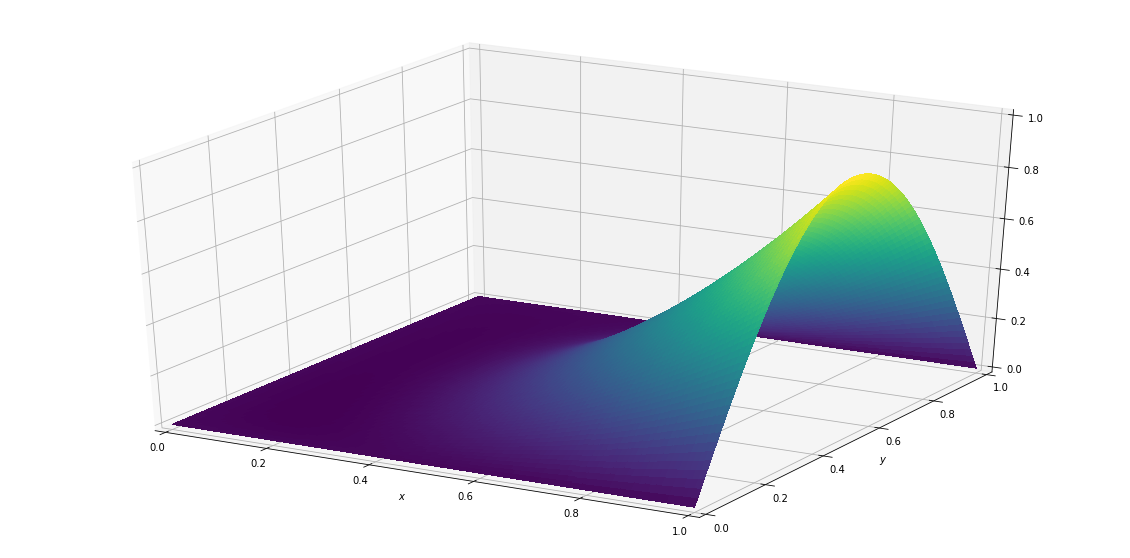

In [20]:
#Plot the neural solution after training 

neural_surface = np.zeros((100, 100))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):  
        neural_surface[i][j] = neural_solution(W0,W1,[x, y])


fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, neural_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');

In [21]:
#WHAT A BEAUTY!

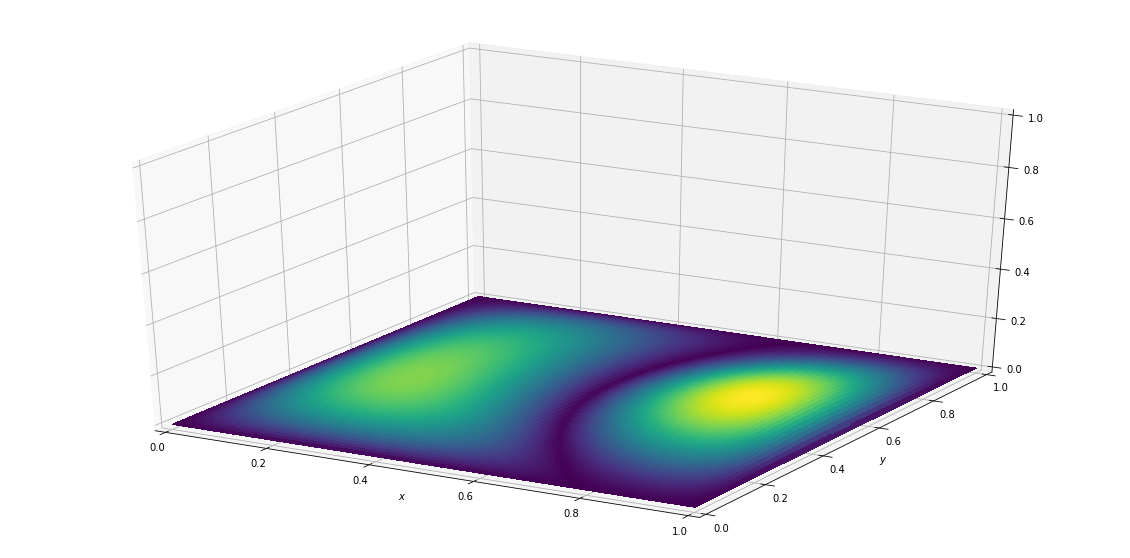

In [22]:
#Let's plot the difference


difference_surface = np.zeros((100, 100))
for i, x in enumerate(x_space):
    for j, y in enumerate(y_space):  
        difference_surface[i][j] = abs(neural_surface[i][j] - analytic_surface[i][j])


fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
X, Y = np.meshgrid(x_space, y_space)
surf = ax.plot_surface(X, Y, difference_surface, rstride=1, cstride=1, cmap=cm.viridis,
        linewidth=0, antialiased=False)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$');